In [1]:
import pandas as pd
import numpy as np
import pickle
import lightgbm as lgb

In [2]:
with open('../../models/customer_risk_target_thomas.pkl', 'rb') as f:
    model = pickle.load(f)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
model.booster_.save_model('../../models/customer_risk_target_thomas.txt')

In [4]:
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_2020-05-14.feather')

In [5]:
len(modeling_df)

1086183

<AxesSubplot:>

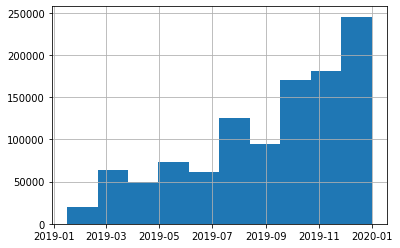

In [6]:
modeling_df.sample_date.hist()

In [7]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

def train_lgb_baseline_grouped(df, features, params, target_col_name='target', group_col_name='business_account_number', num_folds=5, seed=12345, 
                               n_boost_rounds=100000, early_stopping_rounds=1000, verbose_eval=500, weight_col_name=None):
    """
    Train LightGBM models over 5 folds, return OOF predictions, trained models, and average AUC over 5 folds.
    """
    kf = GroupKFold(num_folds)
    split = kf.split(X=df, y=df[target_col_name], groups=df[group_col_name])

    train_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()

    models = []

    for i, (train_idx, test_idx) in enumerate(split):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        if weight_col_name:
            wtr = train[weight_col_name]
            wts = test[weight_col_name]
        else:
            wtr = None
            wts = None
        
        lgb_train = lgb.Dataset(train[features],
                                label=train[target_col_name],
                                free_raw_data=False,
                                weight=wtr)
        lgb_test = lgb.Dataset(test[features],
                               label=test[target_col_name],
                               free_raw_data=False,
                               weight=wts)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          num_boost_round=n_boost_rounds,
                          early_stopping_rounds= early_stopping_rounds,
                          verbose_eval=verbose_eval)
        models.append(model)

        train_pred[test_idx] = model.predict(test[features], num_iteration=model.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                    iteration=model.best_iteration)
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    auc = roc_auc_score(y_true=df[target_col_name].values, y_score=train_pred)

    return train_pred, feature_importance_df, models, auc

In [8]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'giact_time_since_last_link', 'phone_risk_score',
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [9]:
modeling_df = preprocess(modeling_df)

In [12]:
seed = 15556
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "num_iterations": 1400,
    "max_depth" : 4,
    "num_leaves" : 15,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.8,
    "subsample": 0.94,
    "lambda_l1": 16,
    "lambda_l2": 10,
    "min_data_in_leaf": 116,
    "tree_learner": "feature",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed,
    "categorical_feature": [40, 41, 42]
}

count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params['scale_pos_weight'] = pos_wgt_scaling_factor

In [13]:
pred, feature_importance_df, models, auc = train_lgb_baseline_grouped(modeling_df, features, params, target_col_name='target', group_col_name='business_account_number', verbose_eval=500, n_boost_rounds=10000, early_stopping_rounds=150)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973727	test's auc: 0.955304
Early stopping, best iteration is:
[714]	train's auc: 0.977424	test's auc: 0.955604
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973341	test's auc: 0.960582
[1000]	train's auc: 0.980517	test's auc: 0.961588
Early stopping, best iteration is:
[1097]	train's auc: 0.981573	test's auc: 0.961718
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.97378	test's auc: 0.959848
Early stopping, best iteration is:
[710]	train's auc: 0.977168	test's auc: 0.960193
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973306	test's auc: 0.962663
Early stopping, best iteration is:
[544]	train's auc: 0.974197	test's auc: 0.962746
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973359	test's auc: 0.960693
Early stopping, best iteration is:
[560]	train's auc: 0.974

In [14]:
modeling_df['pred'] = pred

In [15]:
# modeling_df.to_feather('../../artifacts//modeling_df_final_with_oof_preds.feather')

In [16]:
# df = pd.read_feather('../../artifacts/modeling_df_final_with_oof_preds.feather')
df = modeling_df

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
roc_auc_score(y_score=df['pred'], y_true=df['target'])

0.960046895168393

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_importances(feature_importance_df_, n_features=None, save_file_path=None):
    if n_features is None:
        n_features = min(50, len(feature_importance_df_['feature'].unique()))
        
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:n_features].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    fig = plt.figure(figsize=(14, 12))
    
    best_features = best_features.sort_values(by='importance', ascending=False)
    
    sns.barplot(x="importance", y="feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if save_file_path:
        plt.savefig(save_file_path)

In [20]:
plt.style.use('seaborn-poster')

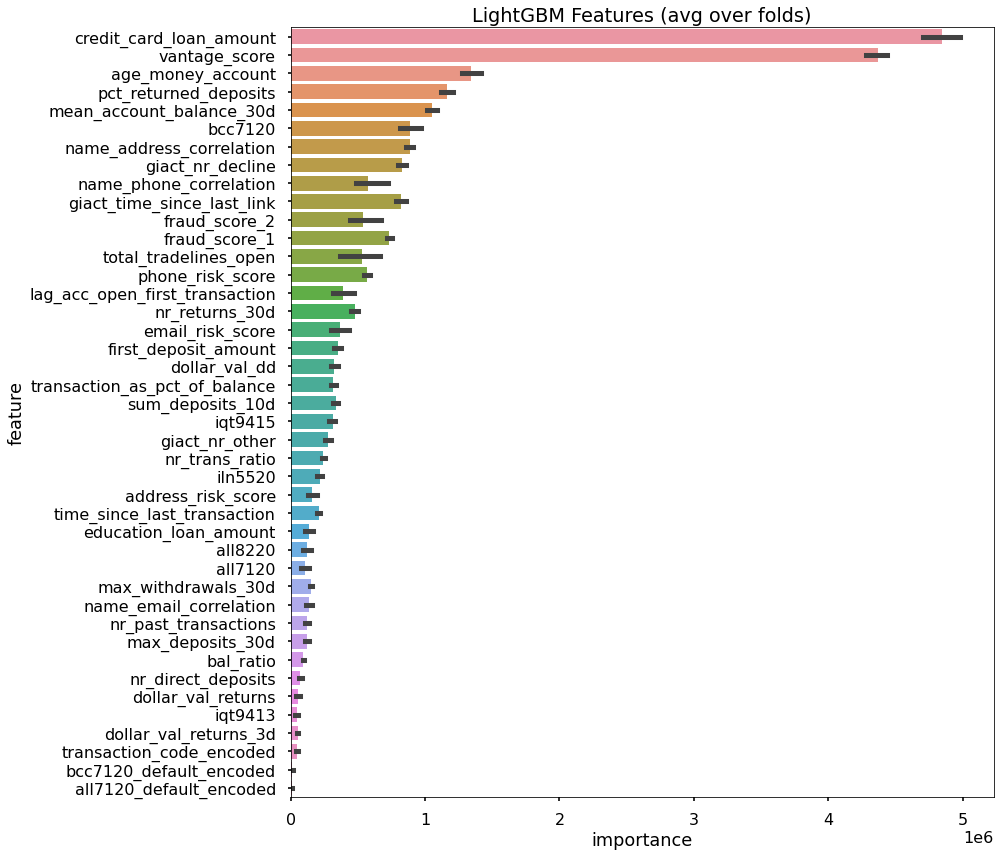

In [21]:
display_importances(feature_importance_df, n_features=None, save_file_path='../../artifacts/fimp_051920_final.png')

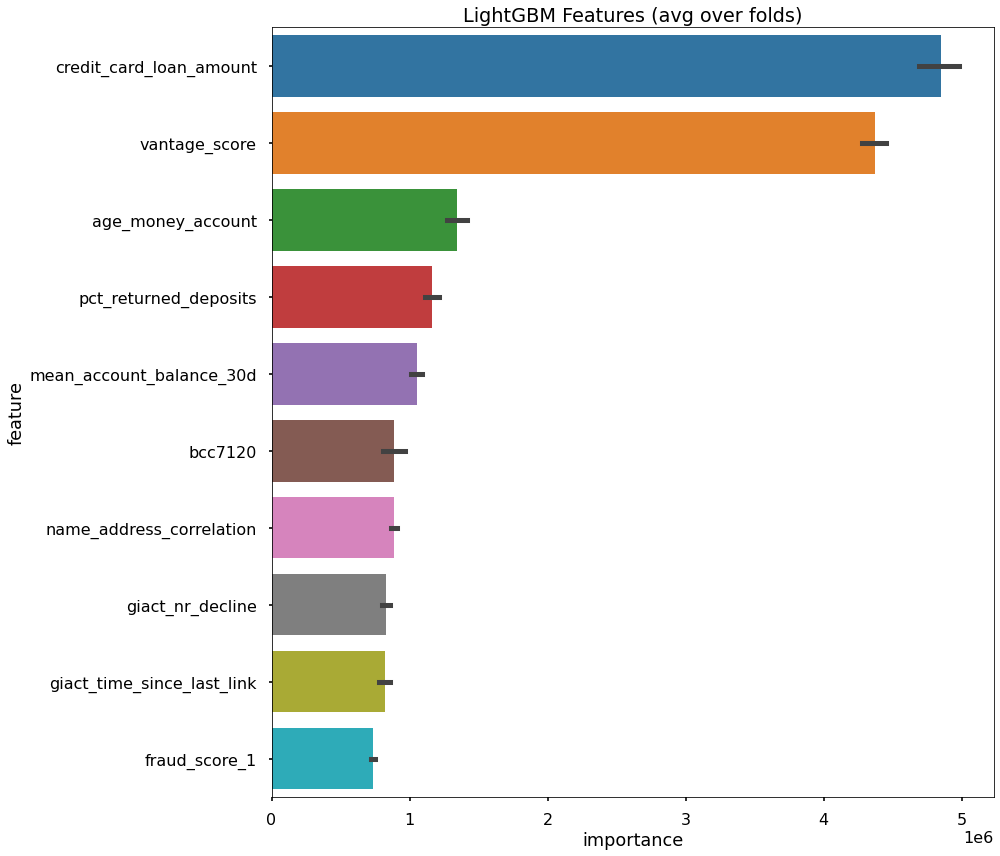

In [22]:
display_importances(feature_importance_df, n_features=10, save_file_path='../../artifacts/fimp_051920_top10_final.png')

In [23]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [24]:
with open('../../artifacts/cv_objects_w_glld.pkl', 'wb') as f:
    result = {'pred': pred, 'feature_importance_df': feature_importance_df, 
              'models': models, 'auc': auc,
              'shap': shap_values, 'features': features}
    pickle.dump(result, f)

In [21]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [22]:
features_by_imp = feature_importance_df.groupby('feature')['importance'].sum().sort_values(ascending=False).index

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


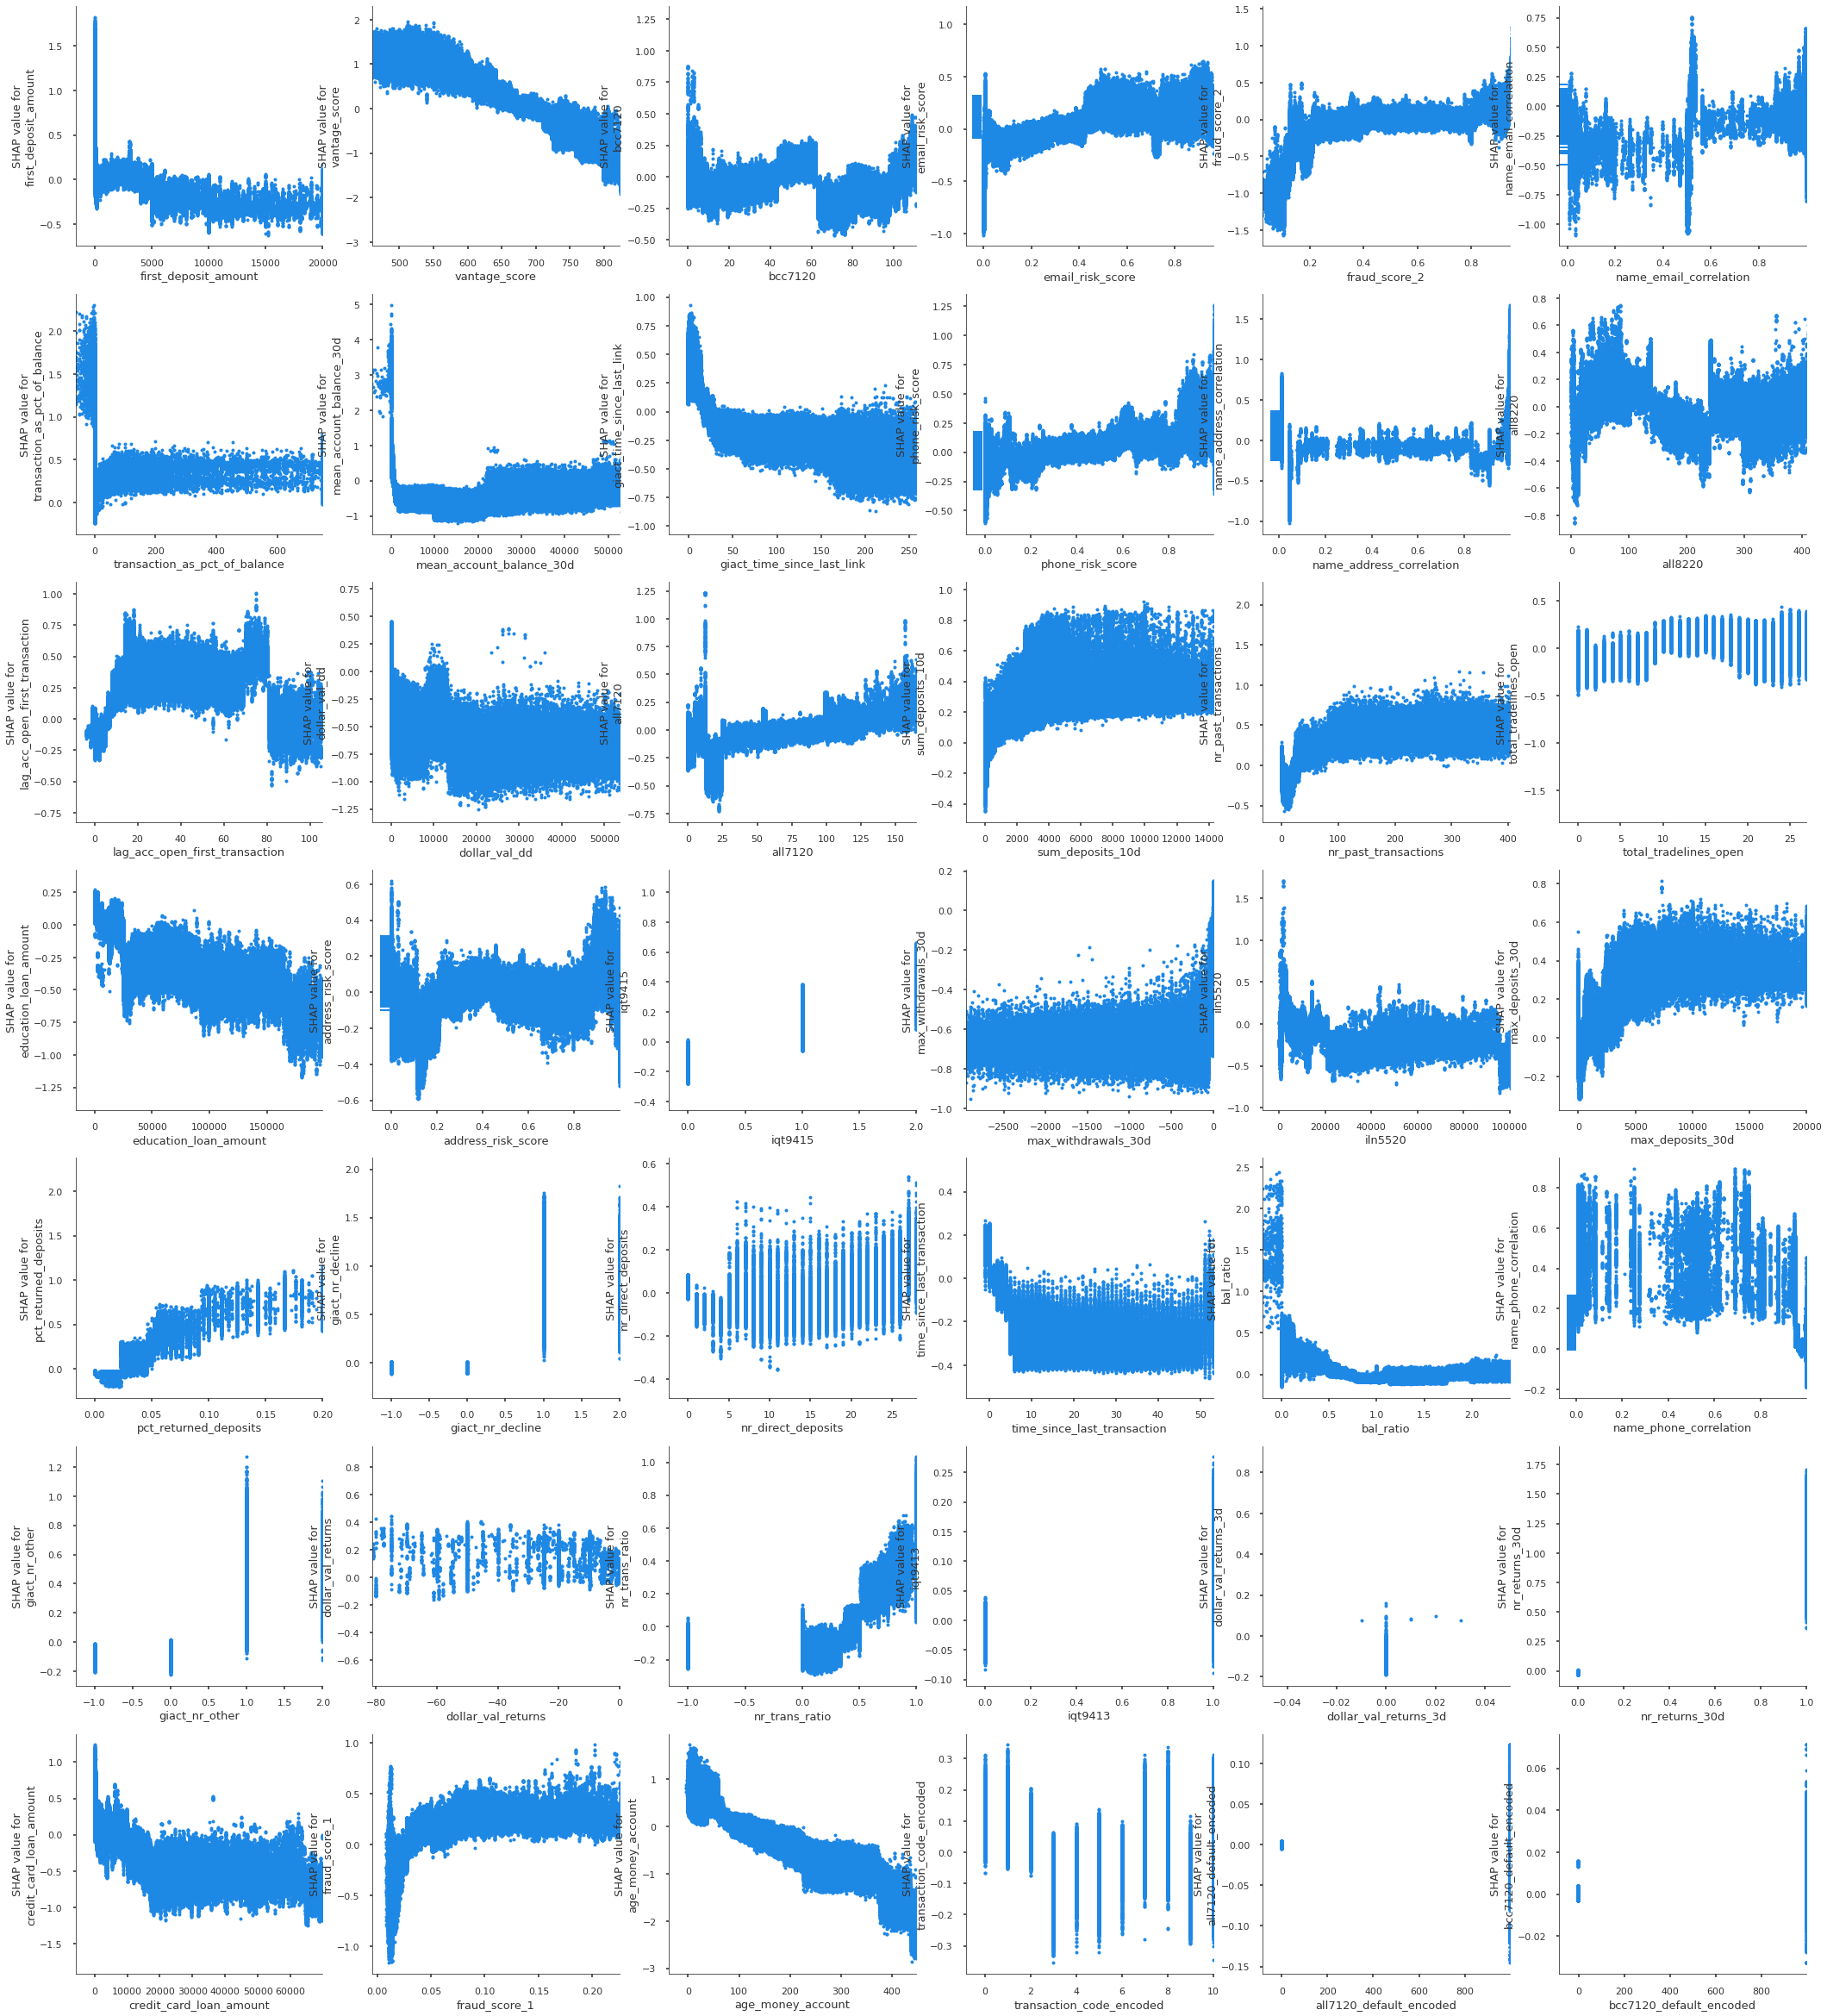

In [23]:
fig = get_shap_dependence(modeling_df[features], shap_values[1], features, interaction_index=None)

In [24]:
fig.savefig('../../artifacts/shap_values_051920_final.png')

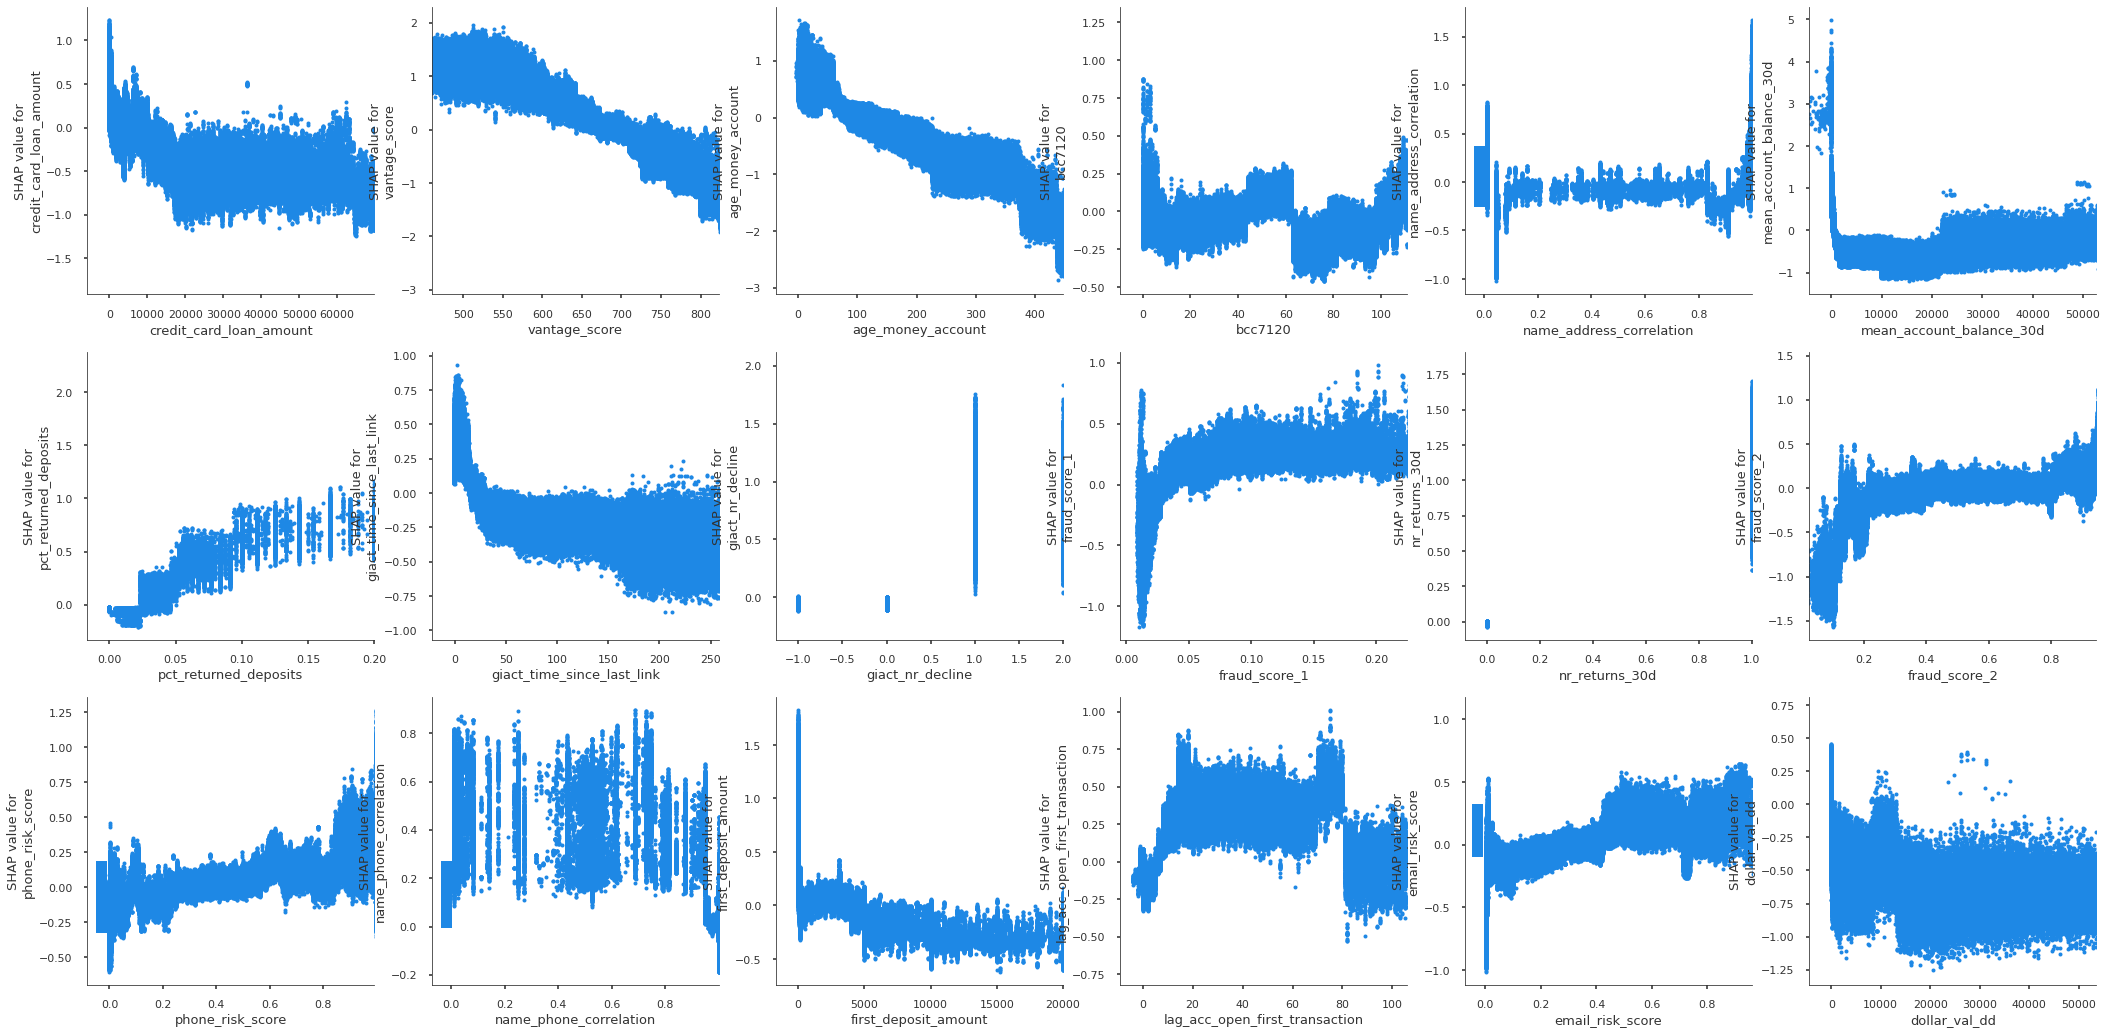

In [25]:
fig = get_shap_dependence(modeling_df[features], shap_values[1], features_by_imp[:18], interaction_index=None)

In [26]:
fig.savefig('../../artifacts/shap_values_051920_top18_final.png')

In [27]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

In [28]:
def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM), MAXIMUM)
   
    return score

In [31]:
modeling_df['score'] = scale_scores(modeling_df['pred'])

In [44]:
build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred').round(2)

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,90.0,0.63,6.50,84.67,108619,41172,7455,67447,970109
1,91.0,0.68,5.55,82.55,97757,40141,8486,57616,979940
2,92.0,0.73,4.63,79.83,86895,38821,9806,48074,989482
3,93.0,0.78,3.74,76.63,76034,37265,11362,38769,998787
4,94.0,0.82,2.89,72.44,65172,35226,13401,29946,1007610
5,95.0,0.86,2.08,67.32,54310,32738,15889,21572,1015984
6,96.0,0.89,1.33,60.88,43448,29602,19025,13846,1023710
7,97.0,0.93,0.68,52.44,32586,25502,23125,7084,1030472
8,98.0,0.96,0.21,40.17,21724,19532,29095,2192,1035364
9,99.0,0.99,0.02,21.93,10862,10665,37962,197,1037359


In [45]:
build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred').round(2)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,1086183,48627,0,1037556,0
1,10.0,0.01,89.54,99.82,977564,48541,86,929023,108533
2,20.0,0.01,79.08,99.65,868946,48457,170,820489,217067
3,30.0,0.02,68.62,99.40,760328,48337,290,711991,325565
4,40.0,0.02,58.16,99.16,651710,48219,408,603491,434065
5,50.0,0.04,47.71,98.78,543092,48034,593,495058,542498
6,60.0,0.06,37.27,98.21,434473,47757,870,386716,650840
7,70.0,0.11,26.87,96.85,325855,47095,1532,278760,758796
8,80.0,0.25,16.52,94.18,217237,45798,2829,171439,866117
9,90.0,0.63,6.50,84.67,108619,41172,7455,67447,970109


In [27]:
roc_auc_score(y_score=modeling_df['pred'], y_true=modeling_df['target'])

0.9602798300110735

In [46]:
print(build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred').round(2).to_csv(index=False))

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.63,6.5,84.67,108619,41172,7455,67447,970109
91.0,0.68,5.55,82.55,97757,40141,8486,57616,979940
92.0,0.73,4.63,79.83,86895,38821,9806,48074,989482
93.0,0.78,3.74,76.63,76034,37265,11362,38769,998787
94.0,0.82,2.89,72.44,65172,35226,13401,29946,1007610
95.0,0.86,2.08,67.32,54310,32738,15889,21572,1015984
96.0,0.89,1.33,60.88,43448,29602,19025,13846,1023710
97.0,0.93,0.68,52.44,32586,25502,23125,7084,1030472
98.0,0.96,0.21,40.17,21724,19532,29095,2192,1035364
99.0,0.99,0.02,21.93,10862,10665,37962,197,1037359



In [49]:
print(build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred').round(2).to_csv(index=False))

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,1086183,48627,0,1037556,0
10.0,0.01,89.54,99.82,977564,48541,86,929023,108533
20.0,0.01,79.08,99.65,868946,48457,170,820489,217067
30.0,0.02,68.62,99.4,760328,48337,290,711991,325565
40.0,0.02,58.16,99.16,651710,48219,408,603491,434065
50.0,0.04,47.71,98.78,543092,48034,593,495058,542498
60.0,0.06,37.27,98.21,434473,47757,870,386716,650840
70.0,0.11,26.87,96.85,325855,47095,1532,278760,758796
80.0,0.25,16.52,94.18,217237,45798,2829,171439,866117
90.0,0.63,6.5,84.67,108619,41172,7455,67447,970109



In [48]:
print(build_table1(modeling_df, np.linspace(0, 99, 100), 'target', 'pred').round(2).to_csv(index=False))

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,1086183,48627,0,1037556,0
1.0,0.0,98.95,99.99,1075321,48620,7,1026701,10855
2.0,0.0,97.91,99.97,1064459,48612,15,1015847,21709
3.0,0.0,96.86,99.95,1053597,48605,22,1004992,32564
4.0,0.0,95.82,99.93,1042735,48595,32,994140,43416
5.0,0.0,94.77,99.9,1031873,48580,47,983293,54263
6.0,0.0,93.72,99.89,1021012,48574,53,972438,65118
7.0,0.0,92.68,99.86,1010150,48561,66,961589,75967
8.0,0.0,91.63,99.85,999288,48555,72,950733,86823
9.0,0.0,90.59,99.84,988426,48548,79,939878,97678
10.0,0.01,89.54,99.82,977564,48541,86,929023,108533
11.0,0.01,88.49,99.81,966702,48536,91,918166,119390
12.0,0.01,87.45,99.79,955841,48527,100,907314,130242
13.0,0.01,86.4,99.78,944979,48522,105,896457,141099
14.0,0.01,85.35,99.77,934117,48517,110,885600,151956
15.0,0.01,84.31,99.76,923255,48512,115,874743,162813
16.0,0.01,8

In [11]:
modeling_df = df

In [12]:
credit_df = pd.read_feather('../data/processed/processed_1589424501/experian_credit_pull_1589424501.feather')

In [13]:
dmd = pd.read_feather('../data/processed/processed_1589424501/user_metadata_dw_1589424501.feather')

In [14]:
credit_df = pd.merge(credit_df[['user_id', 'credit_pull_date', 'fico_score']], dmd[['user_id', 'borrower_id']], how='inner', on='user_id')

In [15]:
import gc

del dmd
gc.collect()

3374

In [16]:
credit_df.head()

,user_id,credit_pull_date,fico_score,borrower_id
0,15768576,2020-04-08,9002.0,9593056
1,14884545,2019-10-27,550.0,8705695
2,15913244,2020-05-12,711.0,9735378
3,15812641,2020-04-20,514.0,9635057
4,15081730,2019-11-25,551.0,8900524


In [17]:
credit_df = credit_df.sort_values(by=['credit_pull_date'])
modeling_df = modeling_df.sort_values(by=['sample_date'])

modeling_df = pd.merge_asof(modeling_df, credit_df, left_on='sample_date', right_on='credit_pull_date', by='borrower_id')

In [18]:
modeling_df['fico_score'].isna().value_counts()

False    907924
True     178259
Name: fico_score, dtype: int64

In [72]:
modeling_df['fico_adjusted'] = modeling_df['fico_score'] * np.where(modeling_df['fico_score'] > 850, 0, 1)

In [73]:
modeling_df['fico_adjusted_2'] = modeling_df['fico_adjusted'].replace(0, np.nan)

In [11]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], 100 - pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] <= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

In [80]:
print(build_table1(modeling_df[~modeling_df['fico_score'].isna()], np.linspace(90, 99, 10), 'target', 'fico_adjusted').round(2).to_csv(index=False))

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,566.0,7.63,57.47,91719,25851,19132,65868,797067
91.0,558.0,6.68,55.39,82550,24915,20068,57635,805300
92.0,547.0,5.66,53.16,72753,23911,21072,48842,814093
93.0,517.0,4.78,49.71,63650,22359,22624,41291,821644
94.0,489.0,3.95,45.77,54672,20587,24396,34085,828850
95.0,444.0,3.15,40.55,45417,18241,26742,27176,835759
96.0,0.0,3.06,39.93,44345,17961,27022,26384,836551
97.0,0.0,3.06,39.93,44345,17961,27022,26384,836551
98.0,0.0,3.06,39.93,44345,17961,27022,26384,836551
99.0,0.0,3.06,39.93,44345,17961,27022,26384,836551



In [81]:
print(build_table1(modeling_df[~modeling_df['fico_score'].isna()], np.linspace(0, 99, 100), 'target', 'fico_adjusted').round(2).to_csv(index=False))

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,850.0,100.0,100.0,907918,44983,0,862935,0
1.0,845.0,99.05,99.85,899635,44915,68,854720,8215
2.0,838.0,98.04,99.74,890864,44868,115,845996,16939
3.0,833.0,97.02,99.67,882013,44834,149,837179,25756
4.0,829.0,95.92,99.65,872570,44826,157,827744,35191
5.0,825.0,94.88,99.51,863535,44763,220,818772,44163
6.0,822.0,93.87,99.45,854732,44736,247,809996,52939
7.0,819.0,92.7,99.41,844655,44718,265,799937,62998
8.0,817.0,92.0,99.38,838564,44703,280,793861,69074
9.0,814.0,90.8,99.24,828175,44641,342,783534,79401
10.0,812.0,89.81,99.23,819661,44638,345,775023,87912
11.0,809.0,88.67,99.09,809748,44574,409,765174,97761
12.0,807.0,87.81,99.04,802333,44553,430,757780,105155
13.0,804.0,86.41,98.98,790149,44525,458,745624,117311
14.0,802.0,85.45,98.86,781830,44468,515,737362,125573
15.0,800.0,84.51,98.82,773690,44453,530,7292

In [86]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [85]:
roc_auc_score(y_true=modeling_df[~modeling_df['fico_score'].isna()]['target'], y_score=1-modeling_df[~modeling_df['fico_score'].isna()]['fico_adjusted'])

0.8782594317750698

In [87]:
average_precision_score(y_true=modeling_df[~modeling_df['fico_score'].isna()]['target'], y_score=1-modeling_df[~modeling_df['fico_score'].isna()]['fico_adjusted'])

0.30119955113612207

In [30]:
from sklearn.metrics import roc_curve

In [32]:
roc_curve = roc_curve(y_score=modeling_df['pred'], y_true=modeling_df['target'])

In [37]:
fpr, tpr, thresh = roc_curve

Text(0.5, 1.0, 'Out of fold (out of sample) ROC curve 5 fold CV')

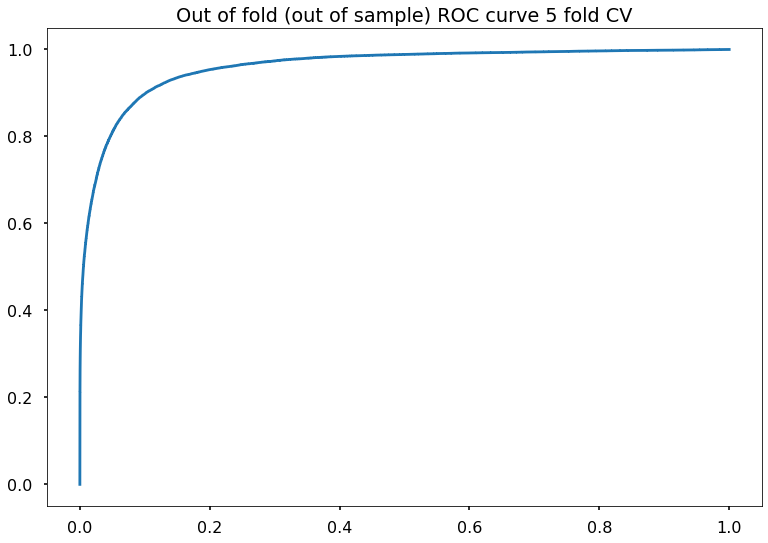

In [40]:
plt.plot(fpr,tpr)
plt.title('Out of fold (out of sample) ROC curve 5 fold CV')

(<Figure size 921.6x633.6 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ee9c62090>)

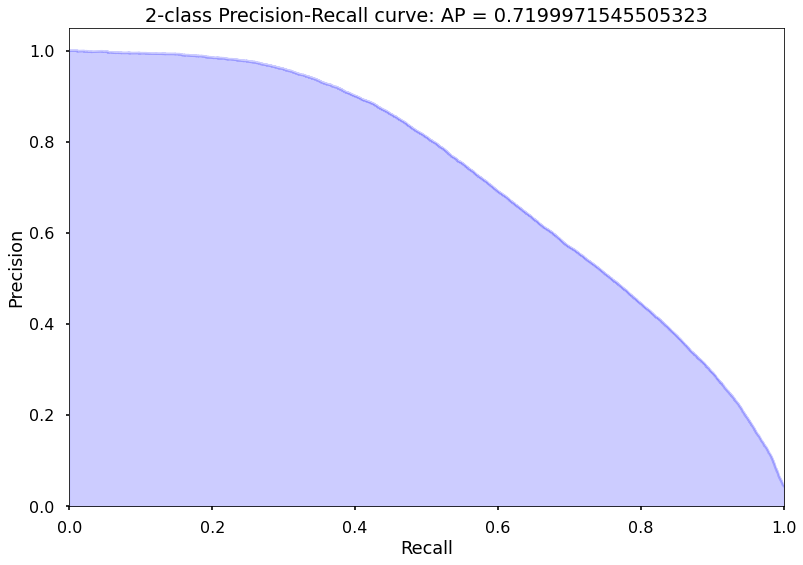

In [38]:
plot_pr_curve(y_true=modeling_df['target'], y_score=modeling_df['pred'])

In [43]:
from sklearn.metrics import average_precision_score

In [42]:
roc_auc_score(y_true=modeling_df.dropna(subset=['vantage_score'])['target'], y_score=1-modeling_df.dropna(subset=['vantage_score'])['vantage_score'])

0.8575425299052285

In [44]:
average_precision_score(y_true=modeling_df.dropna(subset=['vantage_score'])['target'], y_score=1-modeling_df.dropna(subset=['vantage_score'])['vantage_score'])

0.223016919200085

In [45]:
roc_auc_score(y_true=modeling_df.dropna(subset=['fraud_score_2'])['target'], y_score=modeling_df.dropna(subset=['fraud_score_2'])['fraud_score_2'])

0.7515338683450044

In [46]:
average_precision_score(y_true=modeling_df.dropna(subset=['fraud_score_2'])['target'], y_score=modeling_df.dropna(subset=['fraud_score_2'])['fraud_score_2'])

0.18894563521111202

In [50]:
modeling_df[['business_account_number', 'target', 'sample_date', 'pred']].to_csv('oof_pred.csv', index=False)

In [112]:
arr = [[None for i in range(10)] for i in range(10)]

In [94]:
thresh_fico = [np.percentile(modeling_df[~modeling_df['fico_score'].isna()]['fico_adjusted'], 100 - pctl) for pctl in np.linspace(0, 90, 10)]
thresh_pred = [np.percentile(modeling_df[~modeling_df['fico_score'].isna()]['pred'], 100 - pctl) for pctl in np.linspace(0, 90, 10)]

In [98]:
thresh_fico.append(0)

In [97]:
thresh_pred.append(0)

In [101]:
mdf = modeling_df[~modeling_df['fico_adjusted'].isna()]

In [105]:
thresh_pred.append(0)

In [108]:
from tqdm import tqdm

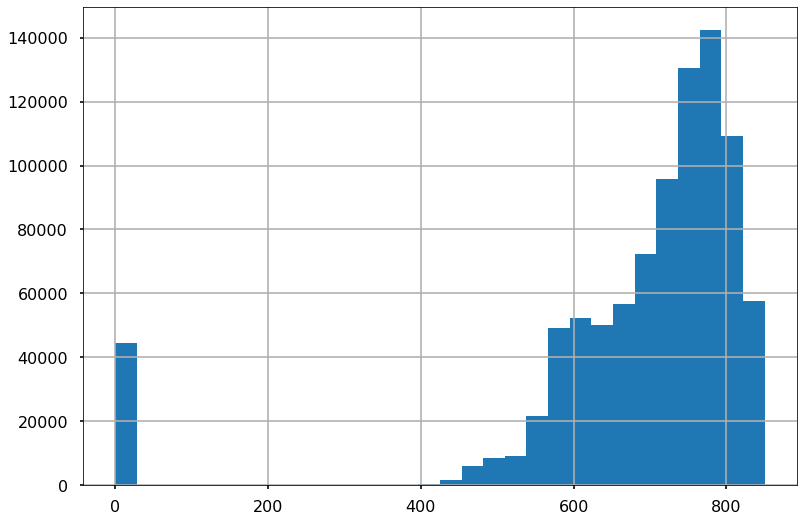

In [133]:
mdf['fico_adjusted'].hist(bins=30)

In [132]:
mdf['fico_adjusted'].between(thresh_fico[0], thresh_fico[1]).value_counts()

False    907918
Name: fico_adjusted, dtype: int64

In [136]:
thresh_pred

[0.9999481905595466,
 0.68736378186744,
 0.2991435841431681,
 0.13619097599243127,
 0.07057057301954232,
 0.041450941746495384,
 0.026149399423124435,
 0.01685320182079528,
 0.010577097754183397,
 0.005874260967084655,
 0]

In [137]:
for i in tqdm(range(len(thresh_fico) - 1)):
    pdf = mdf[mdf['fico_adjusted'].between(thresh_fico[i+1], thresh_fico[i])]
    for j in range(len(thresh_pred) - 1):
        dm = pdf[pdf['pred'].between(thresh_pred[j+1], thresh_pred[j])]
        arr[i][j] = (len(dm['target'])-dm['target'].sum(), dm['target'].sum())

100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


In [139]:
cols = [str(round(thresh_pred[i+1], 2))+'-'+str(round(thresh_pred[i], 2)) for i in range(len(thresh_pred) - 1)]

In [140]:
cols

['0.69-1.0',
 '0.3-0.69',
 '0.14-0.3',
 '0.07-0.14',
 '0.04-0.07',
 '0.03-0.04',
 '0.02-0.03',
 '0.01-0.02',
 '0.01-0.01',
 '0-0.01']

In [141]:
df = pd.DataFrame(arr, columns=cols)

In [143]:
idx = [str(round(thresh_fico[i+1], 2))+'-'+str(round(thresh_fico[i], 2)) for i in range(len(thresh_fico) - 1)]

In [144]:
df.index = idx

In [147]:
print(df.to_csv())

,0.69-1.0,0.3-0.69,0.14-0.3,0.07-0.14,0.04-0.07,0.03-0.04,0.02-0.03,0.01-0.02,0.01-0.01,0-0.01
812.0-850.0,"(295, 154)","(1456, 64)","(3831, 37)","(4760, 20)","(6211, 16)","(8620, 16)","(10841, 16)","(13694, 14)","(17675, 8)","(23636, 6)"
790.0-812.0,"(264, 188)","(1865, 58)","(4559, 55)","(6059, 29)","(8082, 12)","(10821, 10)","(12786, 12)","(14779, 26)","(17098, 9)","(19758, 17)"
772.0-790.0,"(248, 244)","(2156, 96)","(4767, 73)","(6781, 39)","(9259, 31)","(11566, 22)","(13126, 24)","(14343, 14)","(15163, 16)","(15351, 13)"
754.0-772.0,"(393, 173)","(2834, 75)","(6127, 89)","(8373, 29)","(11085, 22)","(12808, 29)","(13833, 23)","(14611, 23)","(14075, 20)","(12110, 8)"
733.0-754.0,"(509, 407)","(3867, 154)","(7507, 106)","(10128, 64)","(12539, 40)","(13168, 20)","(13315, 10)","(12468, 21)","(11438, 17)","(9416, 36)"
705.0-733.0,"(707, 692)","(5033, 242)","(9147, 113)","(12211, 89)","(13412, 40)","(13384, 17)","(12304, 9)","(11125, 4)","(9170, 2)","(7403, 1)"
667.0-705.0,"(1309, 1168)"

#### Tables for the various OOT sets

In [12]:
# 01-06-2020
df_oot = pd.read_csv('../../artifacts/oot_samples_asof_010620_scored_1595615256.csv')

In [13]:
df_oot.head()

,level_0,index,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,...,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred_target
0,470913,470913,2714080,410002038142,2019-07-08 00:00:00.000000,NaN,410,NaN,NaN,311,...,False,False,False,False,False,182,2,-1.0,-1.0,0.000729
1,470914,470914,13471528,410001288367,2019-03-25 00:00:00.000000,NaN,410,NaN,NaN,416,...,False,False,False,False,True,287,0,-1.0,998.0,0.950719
2,470915,470915,12689928,410001017437,2019-03-07 00:00:00.000000,NaN,410,NaN,NaN,434,...,False,False,False,False,True,305,0,-1.0,-1.0,0.025239
3,470916,470916,13471460,410001288655,2019-03-25 00:00:00.000000,NaN,410,NaN,NaN,416,...,False,False,False,False,True,287,0,997.0,998.0,0.809046
4,470917,470917,2725268,410002223673,2019-07-27 00:00:00.000000,NaN,410,NaN,NaN,292,...,False,True,False,False,False,163,6,-1.0,-1.0,0.003241


In [68]:
df_oot['score'] = scale_scores(df_oot['pred_target'])

In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [17]:
import gc

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'{auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'{auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'{auc}, {ap}')

In [71]:
get_metrics(df_oot, 'pred_target')

68.94, 2.42
66.98, 4.55
89.01, 28.34


In [72]:
get_metrics(df_oot[df_oot['nr_transactions_next_90d'] > 0], 'pred_target')

73.84, 7.15
69.58, 15.16
95.62, 52.98


In [73]:
get_metrics(df_oot[(df_oot['nr_past_transactions'] > 0)], 'pred_target')

70.58, 2.91
71.14, 9.32
94.55, 45.96


In [74]:
get_metrics(df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)], 'pred_target')

72.0, 4.83
71.5, 14.4
96.21, 63.07


#### tbl jan

In [75]:
dgd = df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)]
print(build_table1(dgd, np.linspace(90, 99, 10), 'target', 'score').round(2).to_csv(index=False))

del dgd
gc.collect()

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,584.56,8.51,90.28,6360,1049,113,5311,57126
91.0,590.85,7.51,89.33,5724,1038,124,4686,57751
92.0,597.46,6.5,88.47,5088,1028,134,4060,58377
93.0,605.18,5.52,86.57,4452,1006,156,3446,58991
94.0,613.57,4.55,84.17,3816,978,184,2838,59599
95.0,623.18,3.58,81.24,3180,944,218,2236,60201
96.0,633.96,2.65,76.51,2544,889,273,1655,60782
97.0,645.42,1.71,72.29,1908,840,322,1068,61369
98.0,662.16,0.91,60.5,1272,703,459,569,61868
99.0,693.91,0.24,41.65,636,484,678,152,62285



22

#### feb

In [95]:
# 02-17-2020
df_oot = pd.read_csv('../artifacts/oot_samples_asof_021720_scored_1589490907.csv')

In [96]:
get_metrics(df_oot, 'pred_target')

68.5, 2.08
66.1, 3.6
87.37, 24.54


In [97]:
get_metrics(df_oot[df_oot['nr_transactions_next_90d'] > 0], 'pred_target')

73.65, 6.25
68.1, 11.76
94.72, 46.79


In [98]:
get_metrics(df_oot[(df_oot['nr_past_transactions'] > 0)], 'pred_target')

71.56, 2.79
70.37, 7.73
93.71, 39.48


In [99]:
get_metrics(df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)], 'pred_target')

73.41, 4.79
70.42, 12.51
95.75, 58.44


In [101]:
df_oot['score'] = scale_scores(df_oot['pred_target'])
dgd = df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)]
print(build_table1(dgd, np.linspace(90, 99, 10), 'target', 'score').round(2).to_csv(index=False))

del dgd
gc.collect()

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,588.29,8.63,88.98,6596,1001,124,5595,59236
91.0,594.29,7.62,88.36,5936,994,131,4942,59889
92.0,601.11,6.64,86.49,5277,973,152,4304,60527
93.0,608.56,5.66,84.27,4617,948,177,3669,61162
94.0,617.0,4.69,81.33,3958,915,210,3043,61788
95.0,626.02,3.72,78.76,3298,886,239,2412,62419
96.0,636.01,2.77,75.11,2639,845,280,1794,63037
97.0,647.76,1.86,68.8,1979,774,351,1205,63626
98.0,663.13,1.01,58.84,1320,662,463,658,64173
99.0,689.15,0.29,41.96,660,472,653,188,64643



0

#### mar

In [83]:
# 03-15-2020
df_oot = pd.read_csv('../artifacts/oot_samples_asof_031520_scored_1589490924.csv')

In [84]:
get_metrics(df_oot, 'pred_target')

68.51, 1.65
66.11, 2.51
86.96, 22.39


In [85]:
get_metrics(df_oot[df_oot['nr_transactions_next_90d'] > 0], 'pred_target')

73.73, 5.45
68.24, 9.23
94.9, 43.79


In [86]:
get_metrics(df_oot[(df_oot['nr_past_transactions'] > 0)], 'pred_target')

71.53, 2.18
70.35, 5.37
93.5, 35.07


In [87]:
get_metrics(df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)], 'pred_target')

73.52, 4.04
70.44, 9.41
95.85, 54.4


In [88]:
df_oot['score'] = scale_scores(df_oot['pred_target'])
dgd = df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)]
print(build_table1(dgd, np.linspace(90, 99, 10), 'target', 'score').round(2).to_csv(index=False))

del dgd
gc.collect()

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,584.54,8.88,89.13,6218,771,94,5447,55861
91.0,590.96,7.89,87.98,5596,761,104,4835,56473
92.0,597.83,6.9,85.9,4974,743,122,4231,57077
93.0,605.57,5.91,84.39,4353,730,135,3623,57685
94.0,613.08,4.93,81.97,3731,709,156,3022,58286
95.0,621.98,3.96,78.61,3109,680,185,2429,58879
96.0,631.23,3.02,73.64,2487,637,228,1850,59458
97.0,643.54,2.07,69.13,1866,598,267,1268,60040
98.0,658.06,1.16,61.27,1244,530,335,714,60594
99.0,682.62,0.37,45.66,622,395,470,227,61081



22

#### apr

In [89]:
# 02-17-2020
df_oot = pd.read_csv('../artifacts/oot_samples_asof_041520_scored_1589490941.csv')

In [90]:
get_metrics(df_oot, 'pred_target')

69.15, 1.2
65.1, 1.49
87.28, 24.59


In [91]:
get_metrics(df_oot[df_oot['nr_transactions_next_90d'] > 0], 'pred_target')

74.64, 4.44
66.98, 5.8
94.69, 33.45


In [92]:
get_metrics(df_oot[(df_oot['nr_past_transactions'] > 0)], 'pred_target')

71.97, 1.71
69.62, 3.45
94.0, 34.99


In [93]:
get_metrics(df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)], 'pred_target')

74.12, 3.17
69.51, 5.72
95.76, 41.78


In [94]:
df_oot['score'] = scale_scores(df_oot['pred_target'])
dgd = df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)]
print(build_table1(dgd, np.linspace(90, 99, 10), 'target', 'score').round(2).to_csv(index=False))

del dgd
gc.collect()

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,581.68,9.24,88.33,5361,454,60,4907,48182
91.0,588.57,8.24,87.55,4825,450,64,4375,48714
92.0,595.61,7.25,85.8,4289,441,73,3848,49241
93.0,603.24,6.26,84.05,3753,432,82,3321,49768
94.0,611.64,5.29,79.96,3217,411,103,2806,50283
95.0,619.95,4.32,75.88,2681,390,124,2291,50798
96.0,629.47,3.35,71.01,2145,365,149,1780,51309
97.0,640.48,2.4,65.37,1609,336,178,1273,51816
98.0,654.26,1.45,58.56,1073,301,213,772,52317
99.0,676.41,0.57,45.53,537,234,280,303,52786



22

### OOT total performances
---

In [15]:
df_oot1 = pd.read_csv('../../artifacts/oot_samples_asof_010620_scored_1595615256.csv')
df_oot2 = pd.read_csv('../../artifacts/oot_samples_asof_021720_scored_1595615271.csv')
df_oot3 = pd.read_csv('../../artifacts/oot_samples_asof_031520_scored_1595615287.csv')
df_oot4 = pd.read_csv('../../artifacts/oot_samples_asof_041520_scored_1595615305.csv')

In [34]:
df_oot = pd.concat([df_oot1, df_oot2, df_oot3, df_oot4])

In [28]:
cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'giact_time_since_last_link', 'phone_risk_score',
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

In [22]:
get_metrics(df, 'pred_target')

68.48, 1.79
66.11, 2.9
87.82, 24.64


In [25]:
average_precision_score(y_score=df['pred_target'], y_true=df['target'])*100

24.643540921145153

In [30]:
preds = model.predict_proba(df[features])[:,1]

In [33]:
average_precision_score(y_score=preds, y_true=df['target'])*100

24.643540921145153

In [ ]:
import gc

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'{auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'{auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'{auc}, {ap}')

In [35]:
get_metrics(df_oot[(df_oot['nr_transactions_next_90d'] > 0) & (df_oot['nr_past_transactions'] > 0)], 'pred_target')

72.9, 4.2
70.49, 10.3
95.94, 55.91
